<a href="https://colab.research.google.com/github/c-mmonteiro/t2-aprendizado/blob/main/Trabalho3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho 3: Classificação de Animais
Disciplina: Aprendizado de Máquina

Autor: Carlos Monteiro

# 1. Carregamento e separação dos dados

## 1.1 Baixe as imagens do Kaggle (ou conecte ao dataset caso esteja utilizando no Kaggle)

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)

Path to dataset files: /home/carlos-monteiro/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2


In [2]:
import subprocess

subprocess.run(["cp", "-r", path + "/raw-img", "."])

cp: cannot create regular file './raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg': Permission denied
cp: cannot create regular file './raw-img/cane/OIP---A27bIBcUgX1qkbpZOPswHaFS.jpeg': Permission denied
cp: cannot create regular file './raw-img/cane/OIP---ZIdwfUcJeVxnh47zppcQHaFj.jpeg': Permission denied
cp: cannot create regular file './raw-img/cane/OIP---ZRsOF7zsMqhW30WeF8-AHaFj.jpeg': Permission denied
cp: cannot create regular file './raw-img/cane/OIP---_cJbI6Ei26w5bW1urHewHaCf.jpeg': Permission denied
cp: cannot create regular file './raw-img/cane/OIP---cByAiEbIxIAleGo9AqOQAAAA.jpeg': Permission denied
cp: cannot create regular file './raw-img/cane/OIP--0C2kq6I68beB3DduLoxMgHaEf.jpeg': Permission denied
cp: cannot create regular file './raw-img/cane/OIP--0CZnfLuBERVtzRm2QbB3gHaK4.jpeg': Permission denied
cp: cannot create regular file './raw-img/cane/OIP--1QXriWyOTJg-9fEwbznmgHaI4.jpeg': Permission denied
cp: cannot create regular file './raw-img/cane/OIP--2uTtzjaszBfEMCROuLN3wHaLH

CompletedProcess(args=['cp', '-r', '/home/carlos-monteiro/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/raw-img', '.'], returncode=1)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split

2025-10-17 01:23:38.591696: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-17 01:23:38.591728: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-17 01:23:38.592839: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-17 01:23:38.599211: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [3]:
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for device in physical_devices:
        print(f"Device: {device}")
        tf.config.experimental.set_memory_growth(device, True)

Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Device: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


In [4]:
!nvidia-smi

Fri Oct 17 01:23:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     Off |   00000000:17:00.0 Off |                  N/A |
| 28%   50C    P8             11W /  250W |       9MiB /  11264MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
%%time
if os.path.exists('data.csv'):
    df = pd.read_csv('data.csv', index_col=0)
else:
    # Create dataframe with paths and labels of all images
    df = pd.DataFrame()
    for dirname, _, filenames in os.walk("./raw-img"):
        paths = [dirname + '/' + filename for filename in filenames]
        folder_name = os.path.split(dirname)[-1]
        df = pd.concat([df, pd.DataFrame({'path': paths, 'target': folder_name})], ignore_index=True)
    df = df.sort_values('path').reset_index(drop=True)

    # Translate labels to English
    translation = {"cane": "dog",
                   "cavallo": "horse",
                   "elefante": "elephant",
                   "farfalla": "butterfly",
                   "gallina": "chicken",
                   "gatto": "cat",
                   "mucca": "cow",
                   "pecora": "sheep",
                   "ragno": "spider",
                   "scoiattolo": "squirrel"}
    df.loc[:, 'target'] = df['target'].map(translation)

    # Add height and width information
    df.loc[:, ['height', 'width']] = df['path'].apply(lambda fn: Image.open(fn).size[::-1]).to_list()
    df.loc[:, ['min_dim', 'max_dim']] = df.loc[:, ['height', 'width']].apply(lambda row: sorted(row), axis=1).to_list()

    # Add filename extension information
    df.loc[:, 'extension'] = df['path'].apply(lambda s: s.split('.')[-1].lower()).to_list()

    df.to_csv('data.csv')
df

CPU times: user 48.4 ms, sys: 19.1 ms, total: 67.5 ms
Wall time: 65.2 ms


path    target  height  \
0         ./raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg       dog     225   
1      ./raw-img/cane/OIP---A27bIBcUgX1qkbpZOPswHaFS....       dog     214   
2      ./raw-img/cane/OIP---ZIdwfUcJeVxnh47zppcQHaFj....       dog     225   
3      ./raw-img/cane/OIP---ZRsOF7zsMqhW30WeF8-AHaFj....       dog     225   
4      ./raw-img/cane/OIP---_cJbI6Ei26w5bW1urHewHaCf....       dog     101   
...                                                  ...       ...     ...   
26174  ./raw-img/scoiattolo/OIP-zpD7SDCbIqwjYm2A06Oyb...  squirrel     300   
26175  ./raw-img/scoiattolo/OIP-zpZ5t_rN3DA6xByG0o05W...  squirrel     201   
26176  ./raw-img/scoiattolo/OIP-zwWLqRd95U-BjagmhkAgo...  squirrel     209   
26177  ./raw-img/scoiattolo/OIP-zyCc-DDxjCSB5m9DR3uNK...  squirrel     200   
26178  ./raw-img/scoiattolo/OIP-zzy5kEbHuGBWXZ3c-D85a...  squirrel     200   

       width  min_dim  max_dim extension  
0        300      225      300      jpeg  
1        300      214      300      jpeg  
2        300      225      300      jpeg  
3        300      225      300      jpeg  
4        300      101      300      jpeg  
...      ...      ...      ...       ...  
26174    277      277      300      jpeg  
26175    300      201      300      jpeg  
26176    300      209      300      jpeg  
26177    300      200      300      jpeg  
26178    300      200      300      jpeg  

[26179 rows x 7 columns]

## 1.2 Filtre e reduza o dataset para o tamanho desejado

Selecione somente imagens com a extensão .jpg/.jpeg

Selecione somente imagens com largura e altura superior ou igual a 225 e com largura ou altura igual a 300

Selecione somente 150 imagens por classe


In [6]:
df = df.loc[(df['extension'] == 'jpg') | (df['extension'] == 'jpeg')]
df = df.loc[(df['height'] >= 225) & (df['width'] >= 225)]
df = df.loc[(df['height'] == 300) | (df['width'] == 300)]
df = df.groupby('target').head(150)
df = df.reset_index(drop=True)
df

path    target  height  \
0        ./raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg       dog     225   
1     ./raw-img/cane/OIP---ZIdwfUcJeVxnh47zppcQHaFj....       dog     225   
2     ./raw-img/cane/OIP---ZRsOF7zsMqhW30WeF8-AHaFj....       dog     225   
3     ./raw-img/cane/OIP--1QXriWyOTJg-9fEwbznmgHaI4....       dog     300   
4     ./raw-img/cane/OIP--6UY_QQC69uZF4CrwEcfUQHaHa....       dog     300   
...                                                 ...       ...     ...   
1495  ./raw-img/scoiattolo/OIP-DcQf4YaC723GXS-XXV9EF...  squirrel     225   
1496  ./raw-img/scoiattolo/OIP-DlVY-0x9uqexVnZY_1TXx...  squirrel     290   
1497  ./raw-img/scoiattolo/OIP-Dnzd5Zi2pMoZ5xrFNVPeK...  squirrel     300   
1498  ./raw-img/scoiattolo/OIP-DsptawZTCAgdcDrT5SEeq...  squirrel     225   
1499  ./raw-img/scoiattolo/OIP-DuPRPtoVdmJ79aMmVvJk5...  squirrel     259   

      width  min_dim  max_dim extension  
0       300      225      300      jpeg  
1       300      225      300      jpeg  
2       300      225      300      jpeg  
3       251      251      300      jpeg  
4       300      300      300      jpeg  
...     ...      ...      ...       ...  
1495    300      225      300      jpeg  
1496    300      290      300      jpeg  
1497    300      300      300      jpeg  
1498    300      225      300      jpeg  
1499    300      259      300      jpeg  

[1500 rows x 7 columns]

In [7]:
df['height'].max()

300

In [8]:
df['width'].max()

300

In [9]:
df['target'].value_counts()

dog          150
horse        150
elephant     150
butterfly    150
chicken      150
cat          150
cow          150
sheep        150
spider       150
squirrel     150
Name: target, dtype: int64

## 1.3 Observe alguns exemplos de imagens de cada classe

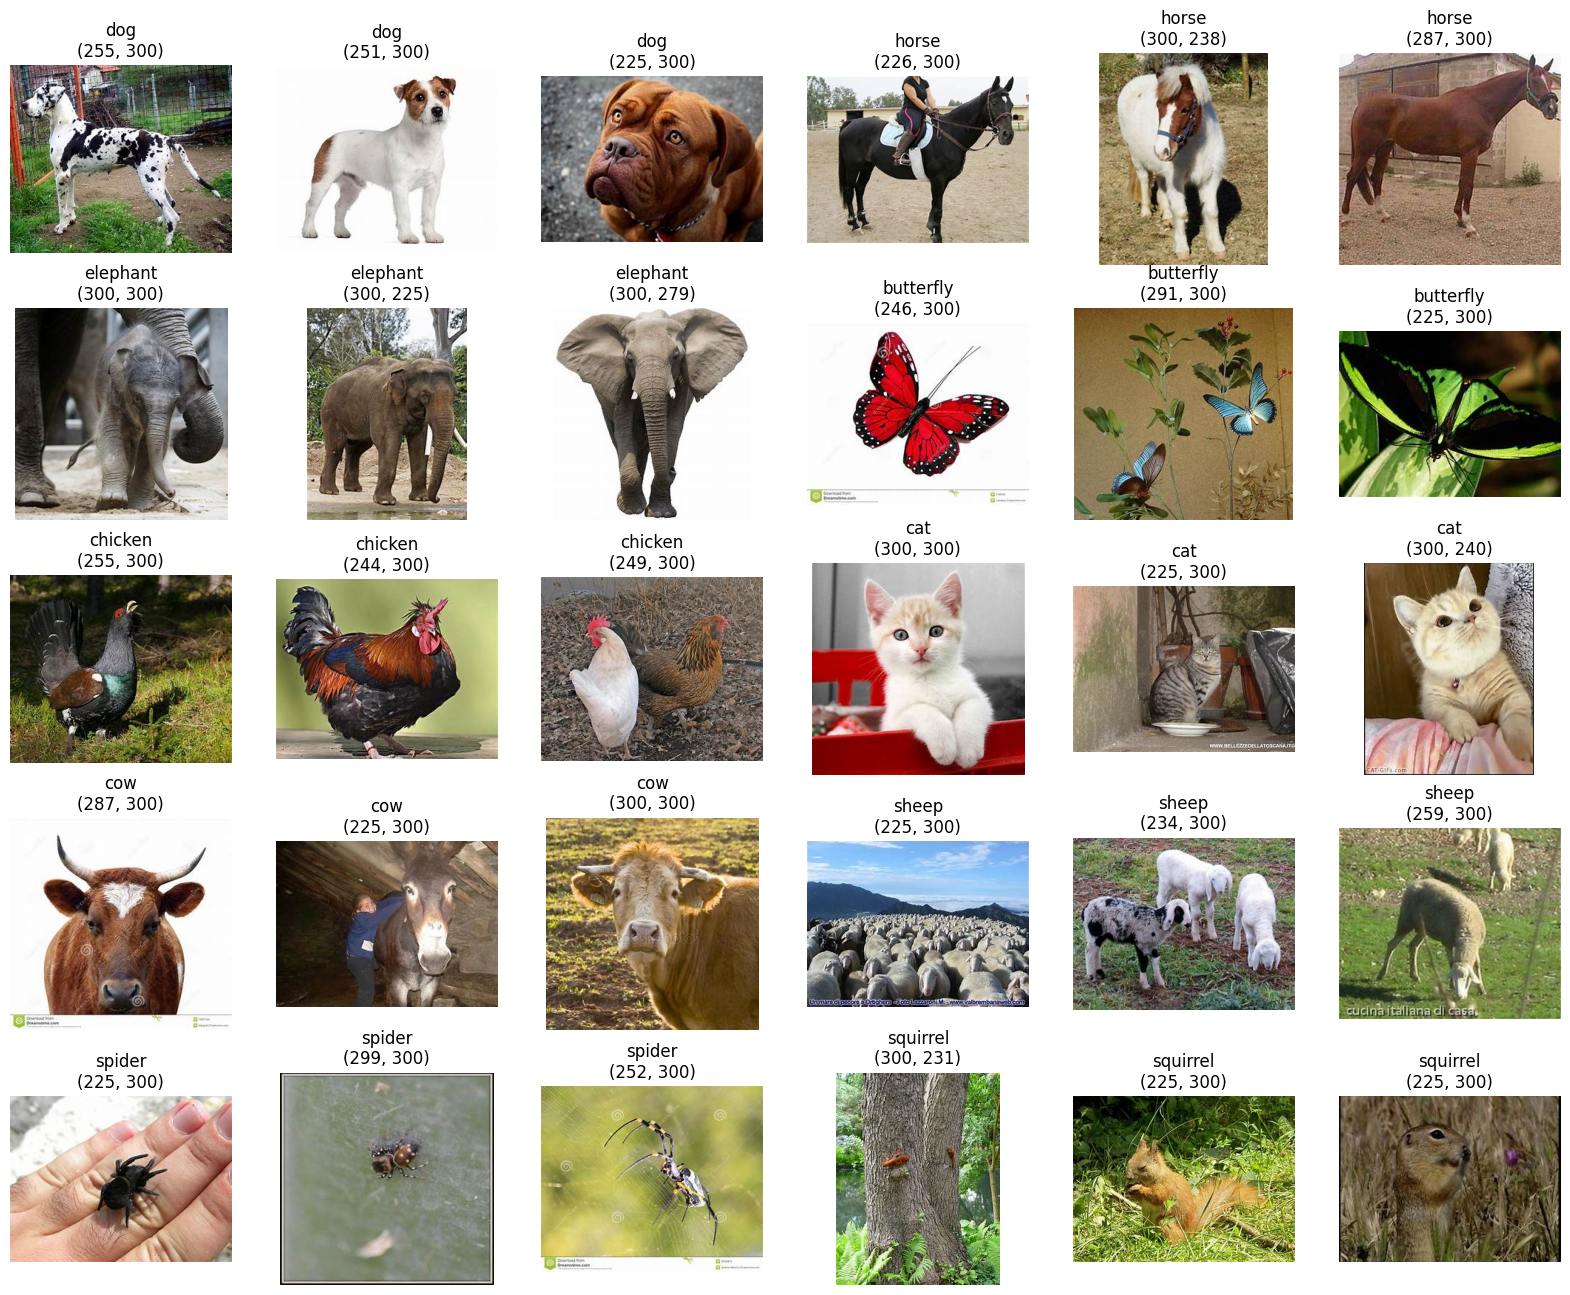

In [10]:
# Show a few examples
plt.figure(figsize=(20, 16))
for i, label in enumerate(df['target'].unique()):
  subset = df['path'][df['target'] == label].sample(3, random_state=0)
  for j in range(3):
    plt.subplot(5, 6, 3*i+j+1)
    img = plt.imread(subset.iloc[j])
    plt.imshow(img)
    plt.title(f'{label}\n{img.shape[:2]}')
    plt.axis('off')

## 1.4 Separe os conjuntos de dados entre treino, treino reduzido, validação e teste conforme especificado na introdução

In [11]:
# Train/val/test split (with the same number of images per class)

images_per_class = 25
random_state = 0
n_classes = len(df['target'].unique())

df_train_val,   df_test = train_test_split(df,            test_size=images_per_class*n_classes, stratify=df['target'],           random_state=random_state)
df_train,       df_val  = train_test_split(df_train_val,  test_size=images_per_class*n_classes, stratify=df_train_val['target'], random_state=random_state)
df_train_small, _       = train_test_split(df_train,     train_size=images_per_class*n_classes, stratify=df_train['target'],     random_state=random_state)

print(f'Train set (full)  : {len(df_train):4d} images ({int(len(df_train)/n_classes):3d} per class)')
print(f'Train set (small) : {len(df_train_small):4d} images ({int(len(df_train_small)/n_classes):3d} per class)')
print(f'Validation set    : {len(df_val):4d} images ({int(len(df_val)/n_classes):3d} per class)')
print(f'Test set          : {len(df_test):4d} images ({int(len(df_test)/n_classes):3d} per class)')

Train set (full)  : 1000 images (100 per class)
Train set (small) :  250 images ( 25 per class)
Validation set    :  250 images ( 25 per class)
Test set          :  250 images ( 25 per class)


In [12]:
def create_dataset(dataframe, img_size, batch_size, seed=None):
    paths = dataframe['path']
    labels = dataframe['target'].map(sorted(dataframe['target'].unique()).index) # ordinal encoder
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.shuffle(len(ds), seed=seed)
    def load_image(path, label):
        image = tf.io.read_file(path)
        image = tf.io.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, img_size)
        return image, label
    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

## 2. Desenvolvimento principal


In [13]:
def plots(history, xlim=None, ylim=None):
  if hasattr(history, 'history'):
    history = history.history
  plt.figure(figsize=(14, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history['loss'], '.-', label='Train loss')
  if 'val_loss' in history.keys():
    plt.plot(history['val_loss'], '.-', label='Val loss')
  plt.xlabel('Epochs');
  plt.legend();
  plt.yscale('log')
  plt.grid(which='both');
  metrics = [m for m in history.keys() if not (m == 'loss' or m.startswith('val_') or m.startswith('Unnamed'))]
  if len(metrics) == 0: return
  plt.subplot(1, 2, 2)
  plt.plot(history[metrics[0]], '.-', label='Train ' + metrics[0])
  plt.xlabel('Epochs');
  if 'val_' + metrics[0] in history.keys():
    v = list(history['val_' + metrics[0]])
    plt.plot(v, '.-', label='Val ' + metrics[0])
    plt.title(f"Val {metrics[0]}: {max(v):.1%} (max) | {v[-1]:.1%} (last)");
  plt.legend();
  plt.xlim(xlim);
  plt.ylim(ylim);
  plt.grid();

In [14]:
from keras.applications.xception import Xception, preprocess_input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras

def make_model(df_train, df_val, batch_size, data_augmentation_layer=None, image_net = True, img_size=(80, 80), epochs=25):

    ds_train = create_dataset(df_train, img_size, batch_size)
    ds_val = create_dataset(df_val, img_size, batch_size)

    if image_net:
        base_model = Xception()
    else:
        base_model = Xception(weights=None)

    input_shape = img_size + (3,)

    base_model = Xception(include_top=False, input_shape=input_shape, pooling='avg')
    base_model.trainable = True
    for layer in base_model.layers:
        if isinstance(layer, keras.layers.BatchNormalization):
            layer.trainable = False

    if data_augmentation_layer is None:
        data_augmentation_layer = keras.layers.Lambda(lambda x: x)

    keras.utils.set_random_seed(0)
    model = keras.Sequential(
        [
            keras.layers.Input(shape=input_shape),
            data_augmentation_layer,
            keras.layers.Lambda(preprocess_input),
            base_model,
            keras.layers.Dense(10, activation='softmax'),
        ]
    )

    model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(0.00001))

    model.summary()

    callbacks = [EarlyStopping(patience=20), ReduceLROnPlateau(factor=0.2, patience=15, verbose=1)]

    history = model.fit(ds_train, validation_data=ds_val, epochs=epochs, callbacks=callbacks, batch_size=batch_size)

    return [history, model]

## 2.1 Modelo baseline

a) Treine um modelo baseline

- Escolha uma arquitetura do Keras Applications como backbone, importe o modelo com os pesos da ImageNet e realize as adaptações necessárias (adição de camada de saída, preprocess_function, etc)

- Escolha alguns parâmetros iniciais como tamanho da imagem (80x80, 100x100, …), um batch_size e taxa de aprendizado adequados, treine o por cerca de 25 épocas e observe o resultado encontrado


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_23 (Lambda)          (None, 80, 80, 3)         0         
                                                                 
 lambda_24 (Lambda)          (None, 80, 80, 3)         0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_12 (Dense)            (None, 10)                20490     
                                                                 
Total params: 20881970 (79.66 MB)
Trainable params: 20772914 (79.24 MB)
Non-trainable params: 109056 (426.00 KB)
_________________________________________________________________
Epoch 1/25
4/4 [==============================] - 10s 319ms/step - loss: 2.6481 - accuracy: 0.0880 - val_loss: 2.4715 - val_accuracy: 0.13

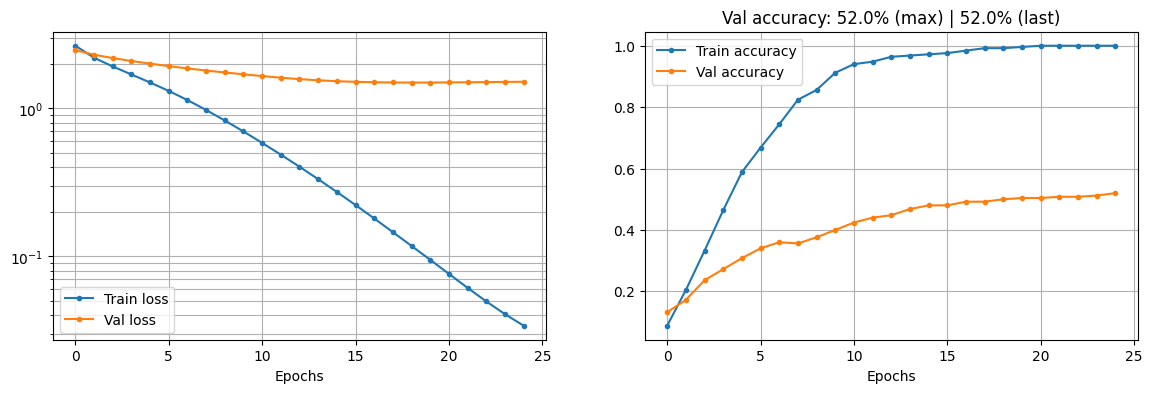

In [31]:
[h, m] = make_model(df_train_small, df_val, 
                    batch_size=64, data_augmentation_layer=None, 
                    image_net=True, img_size=(80, 80), epochs=25)

plots(h)

b) Otimize o batch size e a taxa de aprendizado

In [ ]:
history = []
val_acc = []
batch_size_list = [25, 50, 100, 250]
for batch_size in batch_size_list:
  [h, m] = make_model(df_train_small, df_val, 
                    batch_size=batch_size, data_augmentation_layer=None, 
                    image_net=True, img_size=(80, 80), epochs=25)
  
  history.append(h)
  val_acc.append(h.history['val_accuracy'][-1])

Epoch 1/25
10/10 [==============================] - 10s 134ms/step - loss: 2.5517 - accuracy: 0.1080 - val_loss: 2.3201 - val_accuracy: 0.1640 - lr: 1.0000e-05
Epoch 2/25
10/10 [==============================] - 1s 66ms/step - loss: 1.9108 - accuracy: 0.3240 - val_loss: 2.1221 - val_accuracy: 0.2560 - lr: 1.0000e-05
Epoch 3/25
10/10 [==============================] - 1s 66ms/step - loss: 1.5480 - accuracy: 0.5600 - val_loss: 1.9769 - val_accuracy: 0.3200 - lr: 1.0000e-05
Epoch 4/25
10/10 [==============================] - 1s 65ms/step - loss: 1.2347 - accuracy: 0.6960 - val_loss: 1.8542 - val_accuracy: 0.3600 - lr: 1.0000e-05
Epoch 5/25
10/10 [==============================] - 1s 63ms/step - loss: 0.9497 - accuracy: 0.8120 - val_loss: 1.7512 - val_accuracy: 0.3840 - lr: 1.0000e-05
Epoch 6/25
10/10 [==============================] - 1s 66ms/step - loss: 0.7113 - accuracy: 0.9040 - val_loss: 1.6636 - val_accuracy: 0.4240 - lr: 1.0000e-05
Epoch 7/25
10/10 [==============================] 

In [ ]:
print(f'Acurácia de Validação por Tamanho de Batch:')
print(f'Tamanho do Batch | Acurácia ')
print(f'-----------------|----------')
for i, acc in enumerate(val_acc):
  print(f'{str(batch_size_list[i]).center(17)}| {acc:.4f} ')

Acurácia de Validação por Tamanho de Batch:
 Acurácia | Tamanho do Batch 
----------|------------------
    25    | 0.5560 
    50    | 0.5120 
   100    | 0.5120 
   250    | 0.3800 


## 2.2 Importando ou não os pesos da Imagenet

Repita o teste do caso anterior agora com pesos randomizados em vez dos pesos da ImageNet

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_25 (Lambda)          (None, 80, 80, 3)         0         
                                                                 
 lambda_26 (Lambda)          (None, 80, 80, 3)         0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_13 (Dense)            (None, 10)                20490     
                                                                 
Total params: 20881970 (79.66 MB)
Trainable params: 20772914 (79.24 MB)
Non-trainable params: 109056 (426.00 KB)
_________________________________________________________________
Epoch 1/25
10/10 [==============================] - 10s 135ms/step - loss: 2.5517 - accuracy: 0.1080 - val_loss: 2.3201 - val_accuracy: 0.

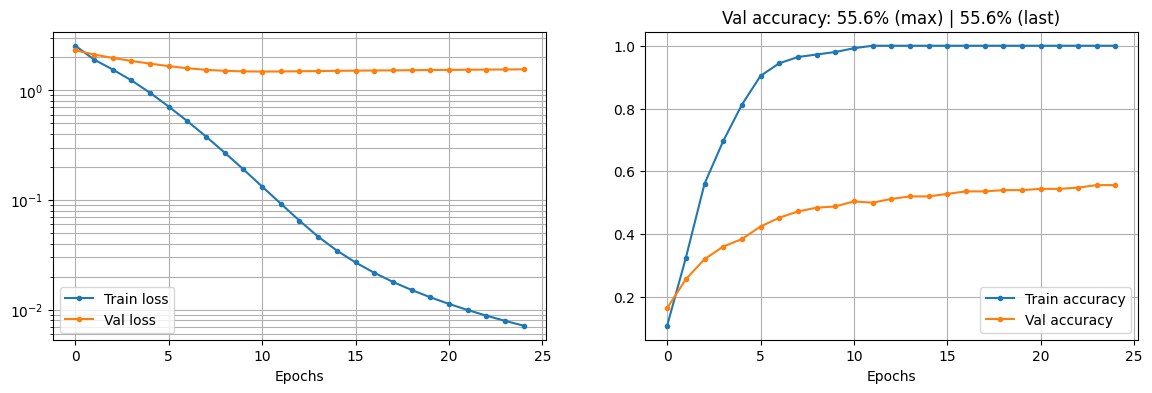

In [32]:
[h, m] = make_model(df_train_small, df_val, 
                    batch_size=25, data_augmentation_layer=None, 
                    image_net=False, img_size=(80, 80), epochs=25)
plots(h)

## 2.3 Data augmentation

Aplique diferentes tipos data augmentation nas imagens, retreine o modelo do item 1. e comente os resultados encontrados (ex: RandomFlip, RandomRotation, RandomContrast, etc)

In [16]:
from keras import layers

data_augmentation1 = keras.Sequential(
    [
        layers.RandomFlip(mode='horizontal'),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1)
    ],
    name='data_augmentation',
)

data_augmentation2 = keras.Sequential(
    [
        layers.RandomFlip(mode='horizontal'),
        layers.RandomRotation(factor=0.1),
    ],
    name='data_augmentation',
)

data_augmentation3 = keras.Sequential(
    [
        layers.RandomFlip(mode='horizontal'),
        layers.RandomZoom(height_factor=0.1, width_factor=0.1)
    ],
    name='data_augmentation',
)

data_augmentation4 = keras.Sequential(
    [
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomRotation(factor=0.1)
    ],
    name='data_augmentation',
)

data_augmentation5 = keras.Sequential(
    [
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomZoom(height_factor=0.1, width_factor=0.1)
    ],
    name='data_augmentation',
)

data_augmentation6 = keras.Sequential(
    [
        layers.RandomRotation(factor=0.1),
        layers.RandomZoom(height_factor=0.1, width_factor=0.1)
    ],
    name='data_augmentation',
)

2025-10-17 01:25:11.293052: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10305 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:17:00.0, compute capability: 6.1
2025-10-17 01:25:11.293711: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10295 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1


In [ ]:
data_augmentation_list = [data_augmentation1, data_augmentation2, data_augmentation3, data_augmentation4, data_augmentation5, data_augmentation6]

history = []
val_acc = []
for data_augmentation in data_augmentation_list:
  [h, m] = make_model(df_train_small, df_val, 
                    batch_size=25, data_augmentation_layer=data_augmentation, 
                    image_net=True, img_size=(80, 80), epochs=25)
  
  history.append(h)
  val_acc.append(h.history['val_accuracy'][-1])


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, 80, 80, 3)         0         
 ial)                                                            
                                                                 
 lambda_27 (Lambda)          (None, 80, 80, 3)         0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_14 (Dense)            (None, 10)                20490     
                                                                 
Total params: 20881970 (79.66 MB)
Trainable params: 20772914 (79.24 MB)
Non-trainable params: 109056 (426.00 KB)
_________________________________________________________________
Epoch 1/25
10/10 [==============================] - 11s 136ms/step - los

In [34]:
print(f'Acurácia de Validação para diferentes camadas de data augmentation:')
print(f'  Camada  | Acurácia ')
print(f'----------|----------')
for i in range(len(data_augmentation_list)):
  print(f'{str(i).center(10)}| {val_acc[i]:.4f} ')

Acurácia de Validação para diferentes camadas de data augmentation:
  Camada  | Acurácia 
----------|----------
    0     | 0.6160 
    1     | 0.6360 
    2     | 0.5840 
    3     | 0.6160 
    4     | 0.5960 
    5     | 0.6200 


## 2.4 Mudança de tamanho

a) Experimente diferentes tamanhos de imagem (até 225x225), meça a acurácia de validação e o tempo de treinamento para cada tamanho de imagem e organize-os em uma tabela ou curvas

In [17]:
history = []
val_acc = []
img_size_list = [(80, 80), (100, 100), (150, 150), (220, 220)]
for img_size in img_size_list:
  [h, m] = make_model(df_train_small, df_val, 
                    batch_size=25, data_augmentation_layer=data_augmentation1, 
                    image_net=True, img_size=img_size, epochs=25)

  history.append(h)
  val_acc.append(h.history['val_accuracy'][-1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, 80, 80, 3)         0         
 ial)                                                            
                                                                 
 lambda (Lambda)             (None, 80, 80, 3)         0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 20881970 (79.66 MB)
Trainable params: 20772914 (79.24 MB)
Non-trainable params: 109056 (426.00 KB)
_________________________________________________________________
Epoch 1/25


2025-10-17 01:25:24.851617: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90100
2025-10-17 01:25:25.286805: I external/local_xla/xla/service/service.cc:168] XLA service 0x61303c8f8090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-17 01:25:25.286834: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-10-17 01:25:25.286840: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-10-17 01:25:25.291814: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1760664325.379760  384343 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 [==============================] - 14s 265ms/step - loss: 2.7317 - accuracy: 0.1360 - val_loss: 2.4552 - val_accuracy: 0.1640 - lr: 1.0000e-05
Epoch 2/25
10/10 [==============================] - 1s 67ms/step - loss: 2.2909 - accuracy: 0.2040 - val_loss: 2.2493 - val_accuracy: 0.1920 - lr: 1.0000e-05
Epoch 3/25
10/10 [==============================] - 1s 69ms/step - loss: 2.0735 - accuracy: 0.2840 - val_loss: 2.1385 - val_accuracy: 0.2400 - lr: 1.0000e-05
Epoch 4/25
10/10 [==============================] - 1s 67ms/step - loss: 1.9409 - accuracy: 0.3360 - val_loss: 2.0566 - val_accuracy: 0.2600 - lr: 1.0000e-05
Epoch 5/25
10/10 [==============================] - 1s 69ms/step - loss: 1.7750 - accuracy: 0.4080 - val_loss: 1.9785 - val_accuracy: 0.2760 - lr: 1.0000e-05
Epoch 6/25
10/10 [==============================] - 1s 68ms/step - loss: 1.6332 - accuracy: 0.4960 - val_loss: 1.8949 - val_accuracy: 0.3120 - lr: 1.0000e-05
Epoch 7/25
10/10 [==============================] - 1s 68ms/s

In [18]:
print(f'Acurácia de Validação para diferentes tamanhos de imagem:')
print(f'  Tamanho | Acurácia ')
print(f'----------|----------')
for i, img_size in enumerate(img_size_list):
  print(f'{str(img_size).center(10)}| {val_acc[i]:.4f} ')

Acurácia de Validação para diferentes tamanhos de imagem:
  Tamanho | Acurácia 
----------|----------
 (80, 80) | 0.6400 
(100, 100)| 0.7320 
(150, 150)| 0.8640 
(220, 220)| 0.9000 


b) Escolha um tamanho de imagem para as próximas questões

Considerando a tabela acima, será utilizado o tamanho 220x220

## 2.5 Mudança de arquitetura

Troque a arquitetura escolhida do Keras Applications e compare com os resultados do Item 4.

94765736/94765736 [==============================] - 3s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 lambda_4 (Lambda)           (None, 220, 220, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_4 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23608202 (90.06 MB)
Trainable params: 23501962 (89.65 MB)
Non-trainable params: 106240 (415.00 KB)
_________________________________________________________________
Epoch 1/

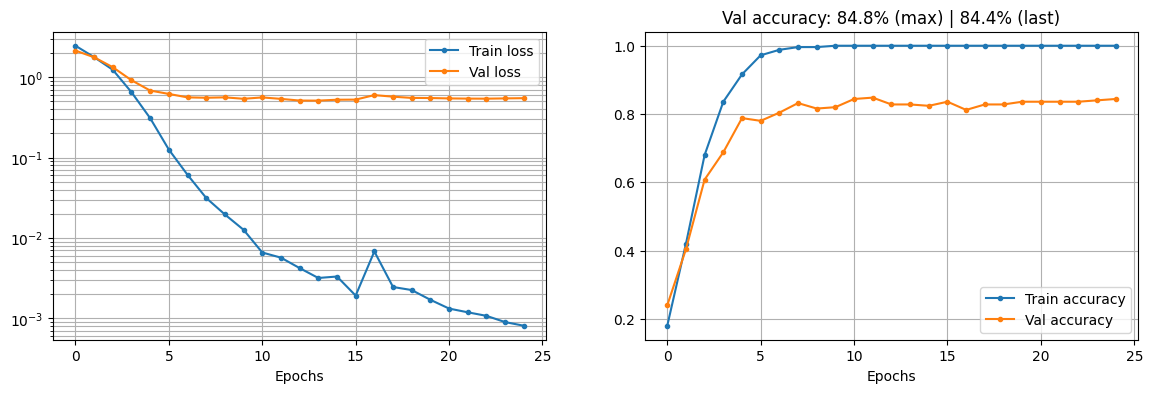

In [24]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras

batch_size=25
data_augmentation_layer=data_augmentation1
img_size=(220, 220)
epochs=25

ds_train = create_dataset(df_train_small, img_size, batch_size)
ds_val = create_dataset(df_val, img_size, batch_size)


base_model = ResNet50()

input_shape = img_size + (3,)

base_model = ResNet50(include_top=False, input_shape=input_shape, pooling='avg')
base_model.trainable = True
for layer in base_model.layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

keras.utils.set_random_seed(0)
model = keras.Sequential(
    [
        keras.layers.Input(shape=input_shape),
        data_augmentation_layer,
        keras.layers.Lambda(preprocess_input),
        base_model,
        keras.layers.Dense(10, activation='softmax'),
    ]
)

model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(0.00001))

model.summary()

callbacks = [EarlyStopping(patience=20), ReduceLROnPlateau(factor=0.2, patience=15, verbose=1)]

history = model.fit(ds_train, validation_data=ds_val, epochs=epochs, callbacks=callbacks, batch_size=batch_size)

plots(history)

## 2.6 Curva de treinamento

